1. Define Problem Statement and perform Exploratory Data Analysis


**Problem Statement:**

Yulu, a leading micro-mobility service provider in India, has experienced a significant drop in revenue. The company aims to understand the factors that influence the demand for their shared electric cycles, particularly in the Indian market.


**Definition of the Problem:**


*   To identify key variables that significantly predict the demand for shared electric cycles.

*   To analyze how well these variables can explain the fluctuations and trends in electric cycle demand.


*   To offer actionable insights based on the analysis that could help Yulu enhance their service utilization and revenue.



**Additional Views:**

1. It could be beneficial to analyze how different demographics (age, income level, occupation) affect the demand for shared electric cycles.

2. Understanding how demand varies by time of day, day of the week, and seasonality could aid in optimizing bike availability.

3. Since Yulu zones are spread across various strategic locations, analyzing the demand at different locations could provide insights into regional preferences and usage patterns.

4. Considering external factors such as public transport strikes, local events, or changes in fuel prices could also provide depth to the understanding of demand shifts.




In [403]:
# Importing the necessery libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# stats libraries
from scipy.stats import ttest_ind # Numeric Vs categorical
from scipy.stats import f_oneway # Numeric Vs categorical for many categories
from scipy.stats import shapiro # To test data is Gaussion 50 - 200 samples.
from scipy.stats import levene # Equality in variance
from scipy.stats import kruskal #In case Assumption in ANOVA test fail same test can be used.
from scipy.stats import chi2_contingency # Dependency of Categorical vs Categorical Columns.


# data validation
from statsmodels.graphics.gofplots import qqplot # visual check for normality of data

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Importing dataset
link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/428/original/bike_sharing.csv?1642089089"
df = pd.read_csv(link)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


* Observations on shape of data, data types of all the attributes, conversion of categorical attributes to 'category' (If required) , missing value detection, statistical summary.

In [5]:
df.shape

(10886, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
# Converting datetime object) column to datetime format/type. and creating new columns Year, Month and Time.
df["datetime"] = pd.to_datetime(df["datetime"])
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df['timestamp'] = df["datetime"].dt.time
df["timestamp"] = pd.to_datetime(df["timestamp"], format = "%H:%M:%S")

#time is in 24 hour format. We can bin the time into bins as below:
# Early Morning: 04:00 - 07:00
# Morning: 07:00 - 12:00
# Afternoon: 12:00 - 16:00
# Evening: 16:00 - 20:00
# Night: 20:00 - 24:00
# Late Night: 00:00 - 04:00 (next day)

bin_labels = ['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']
bin_edges = [-1, 3, 7, 12, 16, 20, 24]
bins_with_labels = pd.cut(df["timestamp"].dt.hour, labels=bin_labels, bins = bin_edges)
df["timestamp_binned"] = bins_with_labels
df.drop("timestamp", axis = 1, inplace = True)

In [8]:
# missing value detection
df.isna().sum()

datetime            0
season              0
holiday             0
workingday          0
weather             0
temp                0
atemp               0
humidity            0
windspeed           0
casual              0
registered          0
count               0
year                0
month               0
timestamp_binned    0
dtype: int64

**Comment 1:** No missing values detected in dataset

In [62]:
# Statistical summary of dataset
round(df.describe(), 2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month
count,10886,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.0,10886.00
mean,2011-12-27 05:56:22.399411968,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57,2011.5,6.52
min,2011-01-01 00:00:00,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00,2011.0,1.00
25%,2011-07-02 07:15:00,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00,2011.0,4.00
50%,2012-01-01 20:30:00,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00,2012.0,7.00
75%,2012-07-01 12:45:00,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00,2012.0,10.00
max,2012-12-19 23:00:00,4.00,1.00,1.00,4.00,41.00,45.46,100.00,57.00,367.00,886.00,977.00,2012.0,12.00
std,NaN,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14,0.5,3.44


**Comment 2:** We have the data between date 01-01-2011 to 19-12-2012 (approx. 2 years of data)

* Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)

 Continuous Variables: temp, atemp, humidity, windspeed, casual, registerd, count

 Categorical Variables: Season, Holiday, Workingday, Weather, Year, timestamp binned

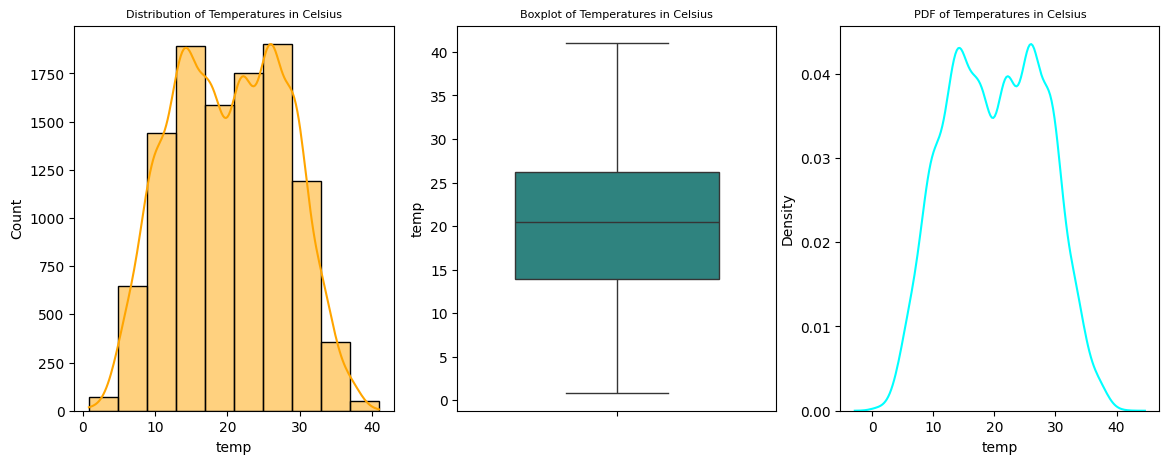

In [12]:
fig, axs = plt.subplots(1,3, figsize = (14,5))
# plotting hisplot, boxplot and kdeplot for temperature.
sns.histplot(data = df, x = "temp", kde = True, color = "orange", ax = axs[0], bins = 10)
axs[0].set_title("Distribution of Temperatures in Celsius", fontsize = 8)

sns.boxplot(data = df, y = "temp", palette="viridis", gap = 1.8, legend = False, ax = axs[1])
axs[1].set_title("Boxplot of Temperatures in Celsius", fontsize = 8)

sns.kdeplot(data = df, x = "temp",  color = "cyan", ax = axs[2])
axs[2].set_title("PDF of Temperatures in Celsius", fontsize = 8)

plt.show()

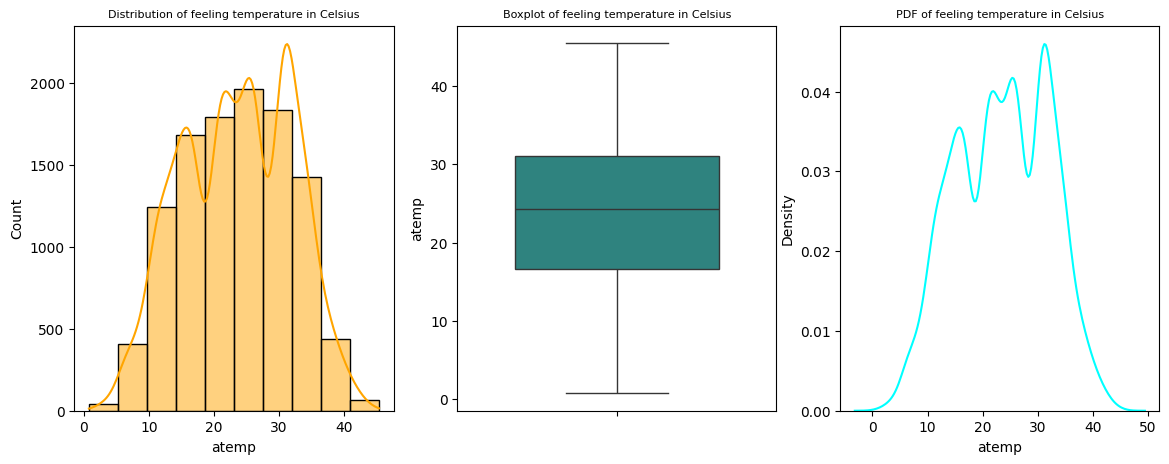

In [13]:
fig, axs = plt.subplots(1,3, figsize = (14,5))
# plotting hisplot, boxplot and kdeplot for atemperature.
sns.histplot(data = df, x = "atemp", kde = True, color = "orange", ax = axs[0], bins = 10)
axs[0].set_title("Distribution of feeling temperature in Celsius", fontsize = 8)

sns.boxplot(data = df, y = "atemp", palette="viridis", gap = 1.8, legend = False, ax = axs[1])
axs[1].set_title("Boxplot of feeling temperature in Celsius", fontsize = 8)

sns.kdeplot(data = df, x = "atemp",  color = "cyan", ax = axs[2])
axs[2].set_title("PDF of feeling temperature in Celsius", fontsize = 8)

plt.show()

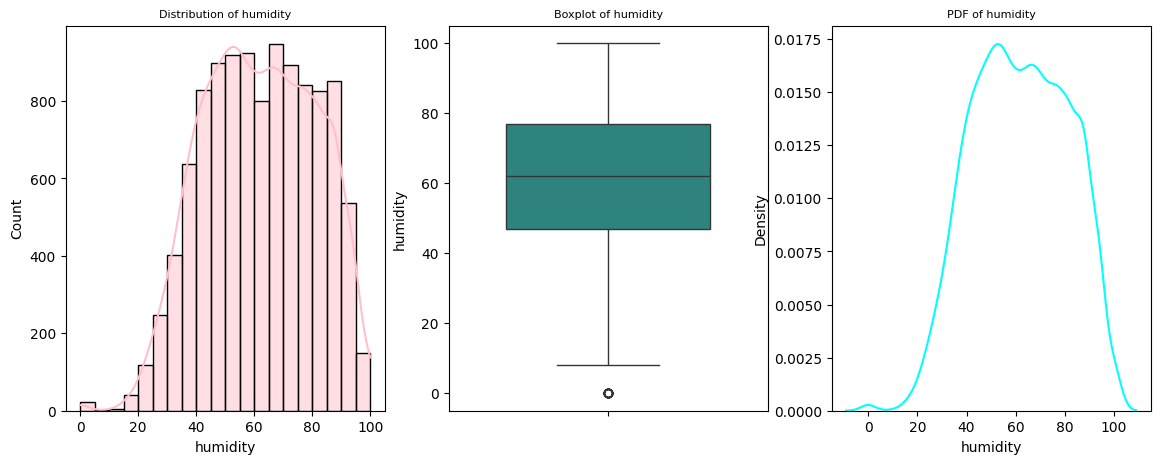

In [14]:
fig, axs = plt.subplots(1,3, figsize = (14,5))
# plotting hisplot, boxplot and kdeplot for humidity.
sns.histplot(data = df, x = "humidity", kde = True, color = "pink", ax = axs[0], bins = 20)
axs[0].set_title("Distribution of humidity", fontsize = 8)

sns.boxplot(data = df, y = "humidity", palette="viridis", gap = 1.8, legend = False, ax = axs[1])
axs[1].set_title("Boxplot of humidity", fontsize = 8)

sns.kdeplot(data = df, x = "humidity",  color = "cyan", ax = axs[2])
axs[2].set_title("PDF of humidity", fontsize = 8)

plt.show()

Comment : Distrubution is  little left skewed and close to normal

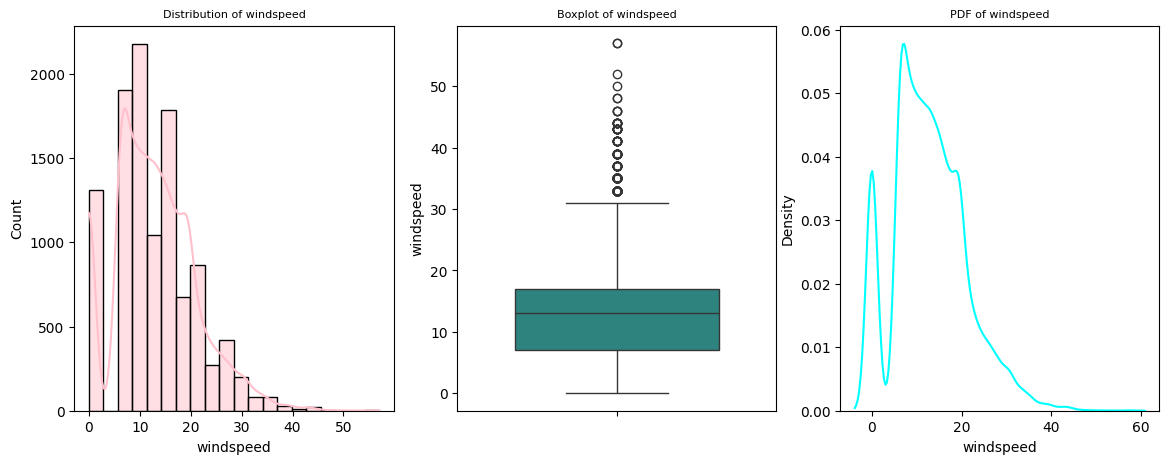

In [15]:
fig, axs = plt.subplots(1,3, figsize = (14,5))
# plotting hisplot, boxplot and kdeplot for windspeed.

sns.histplot(data = df, x = "windspeed", kde = True, color = "pink", ax = axs[0], bins = 20)
axs[0].set_title("Distribution of windspeed", fontsize = 8)

sns.boxplot(data = df, y = "windspeed", palette="viridis", gap = 1.8, legend = False, ax = axs[1])
axs[1].set_title("Boxplot of windspeed", fontsize = 8)

sns.kdeplot(data = df, x = "windspeed",  color = "cyan", ax = axs[2])
axs[2].set_title("PDF of windspeed", fontsize = 8)

plt.show()

Comment : Distrubution is  right skewed

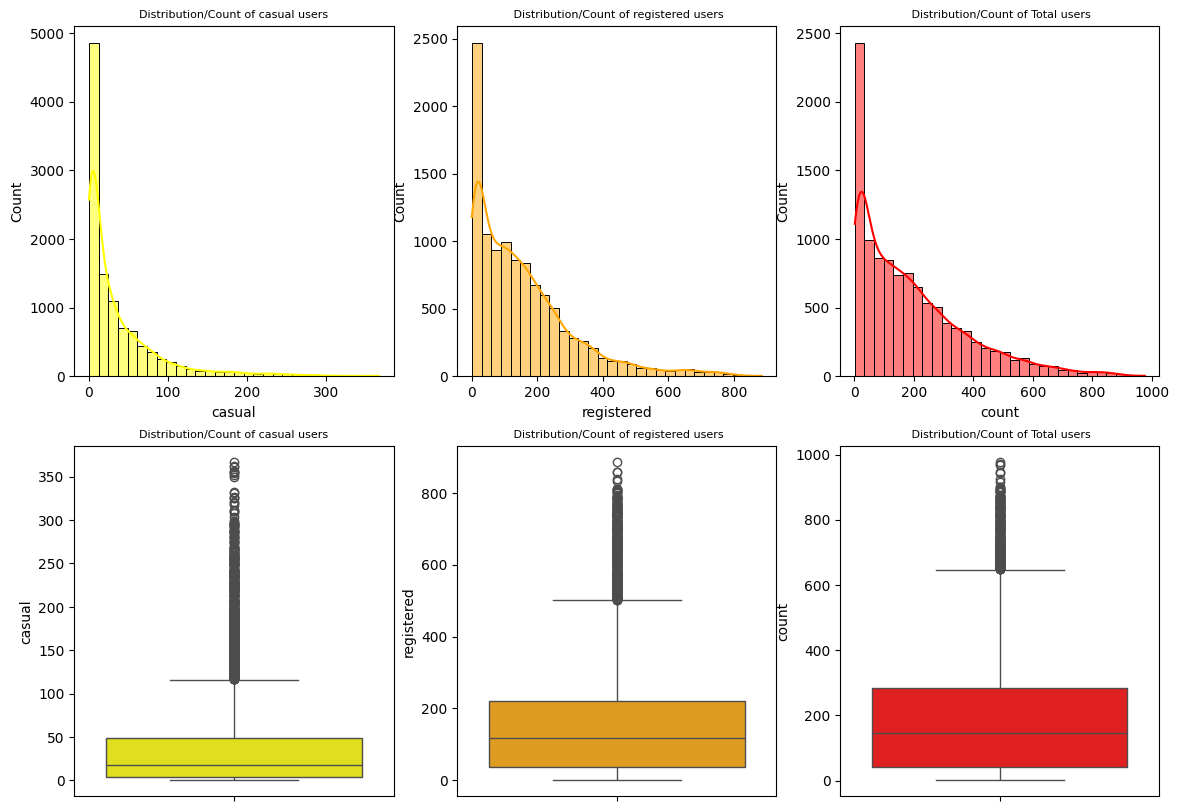

In [113]:
fig, axs = plt.subplots(2,3, figsize = (14,10))
# plotting hisplot, boxplot for different counts.
sns.histplot(data = df, x ="casual", kde = True, bins = 30, ax = axs[0, 0], color = "yellow")
axs[0, 0].set_title("Distribution/Count of casual users", fontsize = 8)

sns.histplot(data = df, x ="registered", kde = True, bins = 30, ax = axs[0, 1], color = "orange")
axs[0, 1].set_title(" Distribution/Count of registered users", fontsize = 8)

sns.histplot(data = df, x ="count", kde = True, bins = 30, ax = axs[0, 2], color = "red")
axs[0, 2].set_title(" Distribution/Count of Total users", fontsize = 8)


sns.boxplot(data = df, y ="casual", ax = axs[1, 0], color = "yellow")
axs[1, 0].set_title("Distribution/Count of casual users", fontsize = 8)

sns.boxplot(data = df, y ="registered",  ax = axs[1, 1], color = "orange")
axs[1, 1].set_title(" Distribution/Count of registered users", fontsize = 8)

sns.boxplot(data = df, y ="count", ax = axs[1, 2], color = "red")
axs[1, 2].set_title(" Distribution/Count of Total users", fontsize = 8)

plt.show()

Comment : Distrubution is  right skewed

In [144]:
# There are outliers in the dataset to find the percenetage of outlier in dataset:
IQR = df["count"].quantile(0.75) - df["count"].quantile(0.25)
Upper = df["count"].quantile(0.75) + 1.5 * IQR
print("count:", round(Upper*100/df["count"].size, 1))

IQR = df["casual"].quantile(0.75) - df["casual"].quantile(0.25)
Upper = df["casual"].quantile(0.75) + 1.5 * IQR
print("casual:", round(Upper*100/df["casual"].size, 1))

IQR = df["registered"].quantile(0.75) - df["registered"].quantile(0.25)
Upper = df["registered"].quantile(0.75) + 1.5 * IQR
print("registered:", round(Upper*100/df["registered"].size, 1))


count: 5.9
casual: 1.1
registered: 4.6


Comment 3:

* 5.9% data is outlier in count column,
* 1.1% is outlier in casual column,
* 4.5% data is outlier in registered column




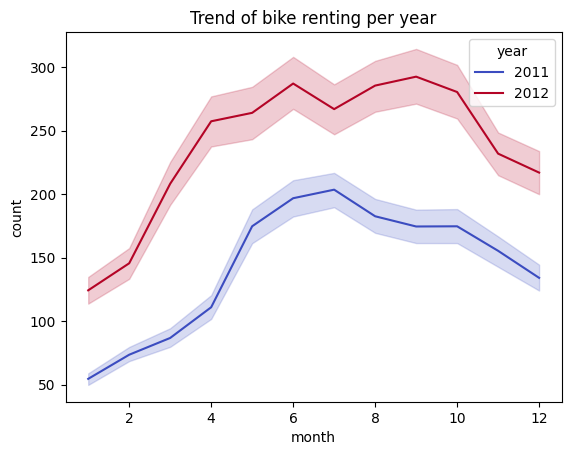

In [204]:
# Plotting trend of Bike renting by Year.
sns.lineplot(data = df, x = "month", y = "count", hue = "year", palette = "coolwarm")
plt.title("Trend of bike renting per year")
plt.show()

Comment 4: It is seen that trend for renting bike has increased in 2012 compared to 2011, similar pattern of trende is obersed in months for both year where count of rented bikes are higher in Q3 of year and less in Q1 of year.

2. Hypothesis Testing.

Steps:
1.   Perform Visual bivariate analysis
2.   Set up Null Hypothesis (H0)
3.   State the alternate hypothesis (H1)
4.   Check assumptions of the test (Normality, Equal Variance).
5.   Set a significance level (alpha)
6.   Calculate test Statistics.
7.   Decision to accept or reject null hypothesis.



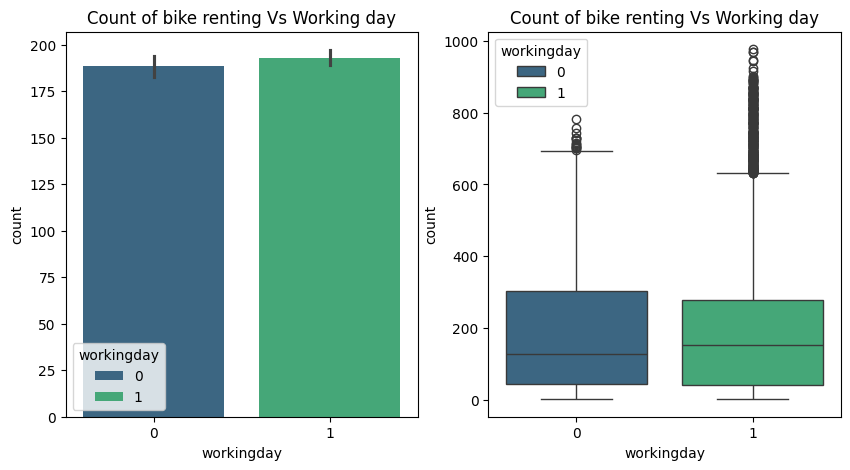

In [224]:
# Working Day has effect on number of electric cycles rented

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y = "count", x = "workingday", estimator = "mean", hue = "workingday", ax = axs[0], palette = "viridis")
axs[0].set_title("Count of bike renting Vs Working day")

sns.boxplot(data = df, y = "count", x = "workingday",  hue = "workingday", ax = axs[1], palette = "viridis")
axs[1].set_title("Count of bike renting Vs Working day")

plt.show()

**Hypothesis Testing 1**

Counts vs working day (2 sample t_test):

Q1. To test whether avg count of working day and non working day equal we will perform t-test with random 30 sample from each catergory.

H0 Null hypothesis: Means of both category are equal/ working day has no significant affect on count of bikes rented.

Alternate hypothesis: Mean of both category are different/ working day has an affect on count of bikes rented.

Significant Level/ alpha = 0.05


In [276]:
# Taking 30 random samples from dataset
Non_working_day = df.loc[df["workingday"] == 0, "count"].sample(30)
Working_day = df.loc[df["workingday"] == 1, "count"].sample(30)

# significance level
alpha = 0.05

# performing 2 sample T_Test
t_statistic, p_value = ttest_ind(Non_working_day,Working_day)

# Decision
if p_value < alpha:
  print("Reject the null hypothesis")

else:
  print("Failed to reject null hyothesis / Means of both category are equal/ working day has no significant an affect on count of bikes rented.")

print("t_statistic:",  t_statistic)
print("p_value:",  p_value)

Failed to reject null hyothesis / Means of both category are equal/ working day has no significant an affect on count of bikes rented.
t_statistic: -0.614967041949338
p_value: 0.5409818245567272


Conclusion 1: After performing T- test on working day and non working day it is found tha working day has no significant an affect on count of bikes rented.

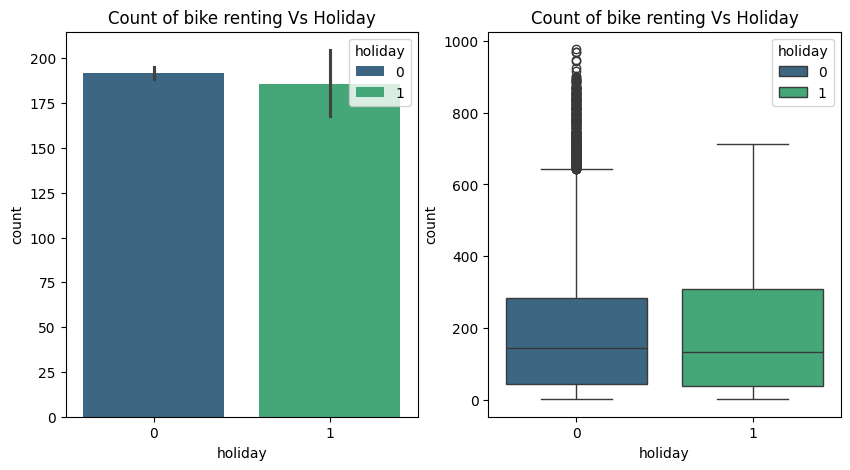

In [280]:
# Holiday has effect on number of electric cycles rented

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y = "count", x = "holiday", estimator = "mean", hue = "holiday", ax = axs[0], palette = "viridis")
axs[0].set_title("Count of bike renting Vs Holiday")

sns.boxplot(data = df, y = "count", x = "holiday",  hue = "holiday", ax = axs[1], palette = "viridis")
axs[1].set_title("Count of bike renting Vs Holiday")

plt.show()

**Hypothesis Testing 2**

Counts vs Holiday. (T-test independant):

Q2. To test whether avg count of holiday day and non holiday day is equal we will perform t-test with random 30 sample from each catergory.

H0 Null hypothesis: Means of both category are equal/ Holiday has no significant affect on count of bikes rented.

Alternate hypothesis: Mean of both category are different/ Holiday has an affect on count of bikes rented.

Significant Level/ alpha = 0.05


In [277]:
# Taking 30 random samples from dataset
Non_Holidays = df.loc[df["holiday"] == 0, "count"].sample(30)
Holidays_days = df.loc[df["holiday"] == 1, "count"].sample(30)

# significance level
alpha = 0.05

# performing 2 sample T_Test
t_statistic, p_value = ttest_ind(Non_Holidays,Holidays_days)

# Decision
if p_value < alpha:
  print("Reject the null hypothesis")

else:
  print("Failed to reject null hyothesis / Means of both category are equal/ working day has no significant an affect on count of bikes rented.")

print("t_statistic:",  t_statistic)
print("p_value:",  p_value)

Failed to reject null hyothesis / Means of both category are equal/ working day has no significant an affect on count of bikes rented.
t_statistic: 0.25524274022323296
p_value: 0.7994385770043194


Conclusion 2: After performing T- test on holidays and non holidays it is found tha holiday has no significant an affect on count of bikes rented.

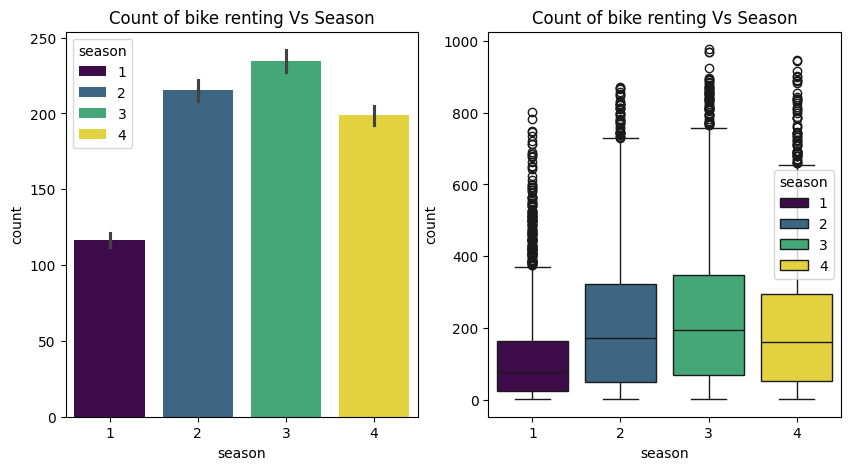

In [286]:
# Season has effect on number of electric cycles rented
# Season (1: spring, 2: summer, 3: fall, 4: winter)

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y = "count", x = "season", estimator = "mean", hue = "season", ax = axs[0], palette = "viridis")
axs[0].set_title("Count of bike renting Vs Season")

sns.boxplot(data = df, y = "count", x = "season",  hue = "season", ax = axs[1], palette = "viridis")
axs[1].set_title("Count of bike renting Vs Season")

plt.show()

**Hypothesis Testing 3**

Counts vs seasons. (ANOVA or Kruskal):

Q3. To test whether No. of cycles rented similar or different in different seasons

H0 Null hypothesis: No. of cycles rented  are similar irrespective of season/
 States that the means of all groups are equal.

Alternate hypothesis: No. of cycles rented are different in different seasons / States that at least one of the means is different/ Seasons affect count of bike rented.

Significant Level/ alpha = 0.05





---

ANOVA requires 3 Assumptions:

1. Data should be normally distributed (i.e, Gaussian)
2. Data should be independent across each record
3. Equal variance in different groups


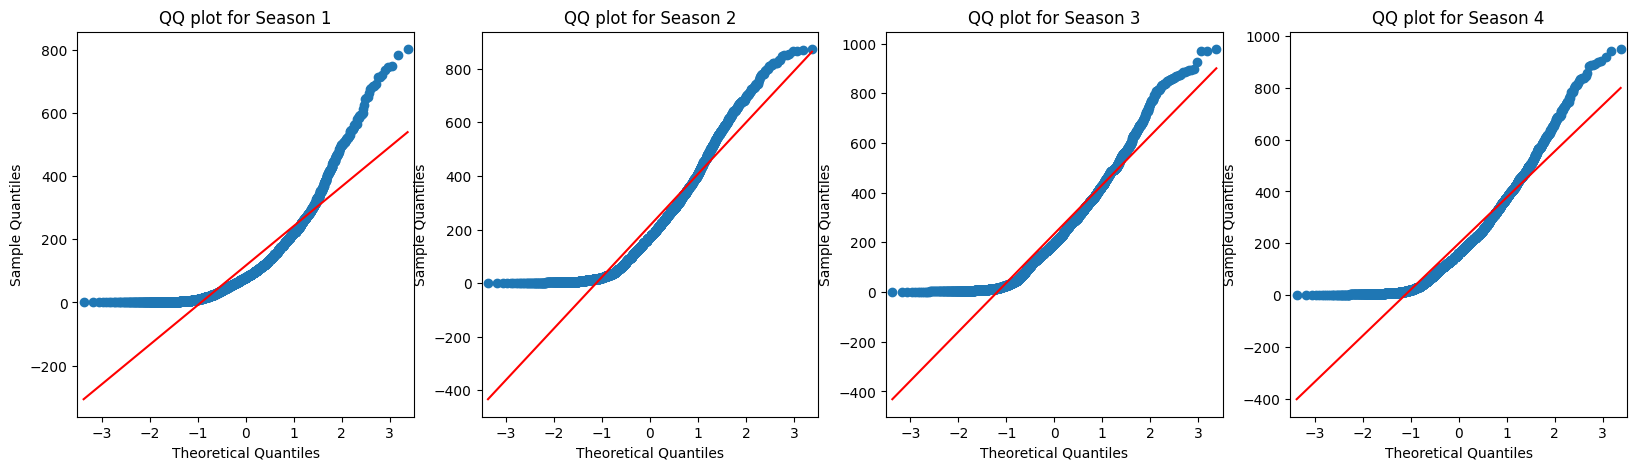

In [333]:
# Visual check for normality
season_1 = df.loc[df["season"] == 1, "count"]
season_2 = df.loc[df["season"] == 2, "count"]
season_3 = df.loc[df["season"] == 3, "count"]
season_4 = df.loc[df["season"] == 4, "count"]

fig, axs = plt.subplots(1,4, figsize = (20,5))

qqplot(season_1, line = "s", ax = axs[0])
axs[0].set_title("QQ plot for Season 1")

qqplot(season_2, line = "s", ax = axs[1])
axs[1].set_title("QQ plot for Season 2")

qqplot(season_3, line = "s", ax = axs[2])
axs[2].set_title("QQ plot for Season 3")

qqplot(season_4, line = "s", ax = axs[3])
axs[3].set_title("QQ plot for Season 4")

plt.show()

It is clearly seen that data is not Gaussian

In [345]:
# Statistical test for normality: Shapiro Wilk test

# H0 : Data is Gaussian
# H1 : Dat is not Gaussian

# If the p-value is high (greater than, say, 0.05),
# It suggests that the data likely does come from a normal distribution.

# Conversely, if the p-value is low (less than 0.05),
# It indicates that the data's distribution significantly differs from a normal distribution.

test_stat, p_value = shapiro(season_1.sample(100))
if p_value < 0.05:
  print("Data is not normal for season_1")
else:
  print("Data is normal")


test_stat, p_value = shapiro(season_2.sample(100))
if p_value < 0.05:
  print("Data is not normal for season_2")
else:
  print("Data is normal")

test_stat, p_value = shapiro(season_3.sample(100))
if p_value < 0.05:
  print("Data is not normal for season_3")
else:
  print("Data is normal")

test_stat, p_value = shapiro(season_4.sample(100))
if p_value < 0.05:
  print("Data is not normal for season_4")
else:
  print("Data is normal")

Data is not normal for season_1
Data is not normal for season_2
Data is not normal for season_3
Data is not normal for season_4


By shapiro test it is obeserved that data is not normal



---

Check for variance of data for each season

Another assumption of ANOVA is that: There should be equal variance in different
groups/categories in our data.



Variance for each season
1    15693.568534
2    36867.011826
3    38868.517013
4    31549.720317
Name: count, dtype: float64


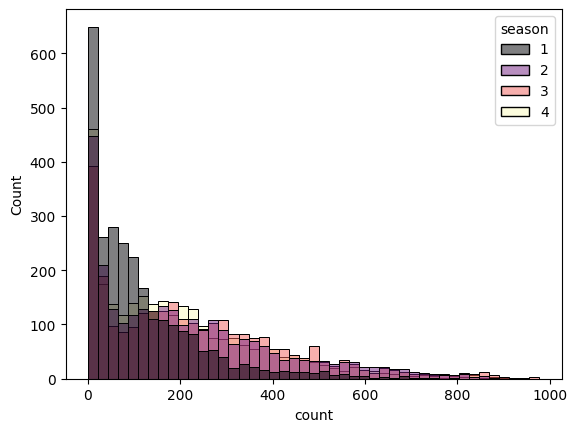

In [356]:
# Visual check for variance
sns.histplot(data = df, x = "count", hue = "season", palette = "magma")
print("Variance for each", df.groupby(by = "season")["count"].var())

Visually it is difficult to understand variance

In [363]:
test_stat, p_value = levene(season_1, season_2, season_3, season_4)

if p_value < 0.05:
  print("There is difference in Variance")
else:
  print("Variance is same for all seasons")

print()
print("Test statistic:", test_stat)
print("p_value:", p_value)

There is difference in Variance

Test statistic: 187.7706624026276
p_value: 1.0147116860043298e-118


By levene test it is obeserved that data has difference in variance.

Since Both assuptions for ANONA are failed we cannot use f-oneway, lets test Kruskal-Wallis test

In [371]:
test_stat, p_value = kruskal(season_1, season_2, season_3, season_4)

if p_value < 0.05:
  print("No. of cycles rented are different in different seasons / States that at least one of the means is different/ Seasons affect count of bike rented.")
else:
  print("No. of cycles rented are similar irrespective of season/ States that the means of all groups are equal.")

print()
print("Test statistic:", test_stat)
print("p_value:", p_value)

No. of cycles rented are different in different seasons / States that at least one of the means is different/ Seasons affect count of bike rented.

Test statistic: 699.6668548181988
p_value: 2.479008372608633e-151


Conclusion 3: After performing Kruskal Wallis Test No. of cycles rented are different in different seasons / States that at least one of the means is different/ Seasons affect count of bike rented.

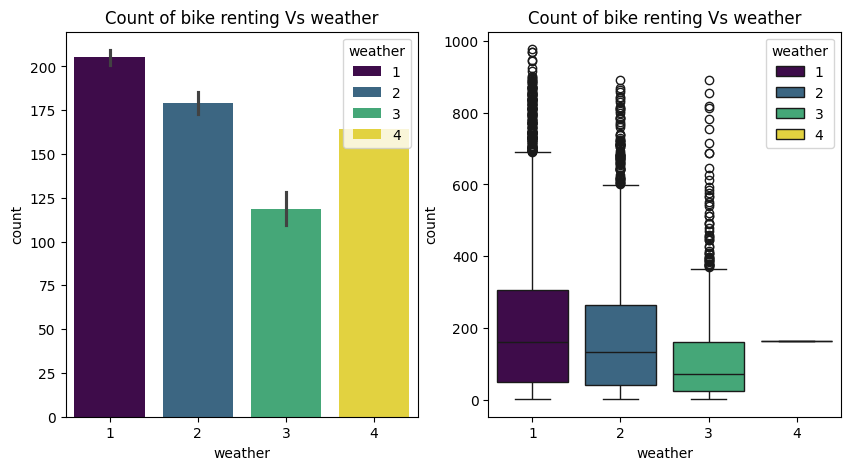

In [374]:
# weather has effect on number of electric cycles rented
# weather:(
# 1: Clear, Few clouds, partly cloudy, partly cloudy,
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y = "count", x = "weather", estimator = "mean", hue = "weather", ax = axs[0], palette = "viridis")
axs[0].set_title("Count of bike renting Vs weather")

sns.boxplot(data = df, y = "count", x = "weather",  hue = "weather", ax = axs[1], palette = "viridis")
axs[1].set_title("Count of bike renting Vs weather")

plt.show()

In [377]:
df[df["weather"] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,timestamp_binned
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,Evening


since there is only 1 row for weather 4 we will drop this row for furthe analysis.

In [379]:
df.drop(index = 5631, inplace = True)

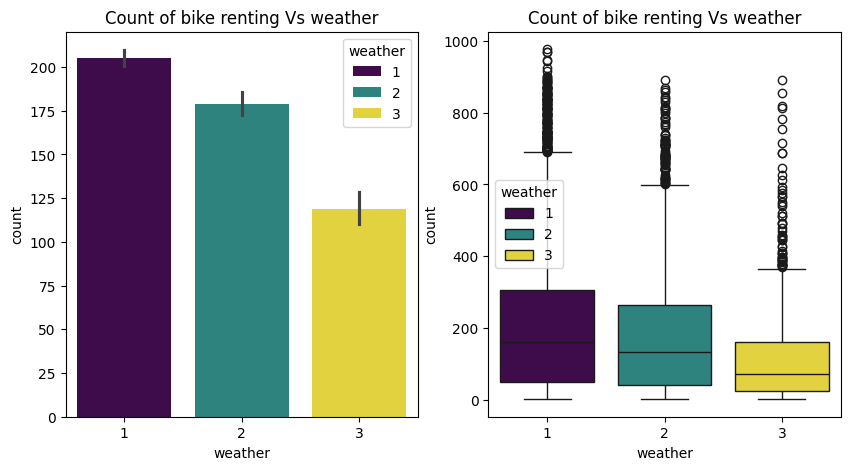

In [380]:
# weather has effect on number of electric cycles rented
# weather:(
# 1: Clear, Few clouds, partly cloudy, partly cloudy,
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y = "count", x = "weather", estimator = "mean", hue = "weather", ax = axs[0], palette = "viridis")
axs[0].set_title("Count of bike renting Vs weather")

sns.boxplot(data = df, y = "count", x = "weather",  hue = "weather", ax = axs[1], palette = "viridis")
axs[1].set_title("Count of bike renting Vs weather")

plt.show()



---

**Hypothesis Testing 4**

Counts vs weather. (ANOVA or Kruskal):

Q3. To test whether No. of cycles rented similar or different in different weather

H0 Null hypothesis: No. of cycles rented are similar irrespective of weather/ States that the means of all groups are equal.

Alternate hypothesis: No. of cycles rented are different in different weather / States that at least one of the means is different/ weather affect count of bike rented.

Significant Level/ alpha = 0.05

ANOVA requires 3 Assumptions:

Data should be normally distributed (i.e, Gaussian)

Data should be independent across each record

Equal variance in different groups

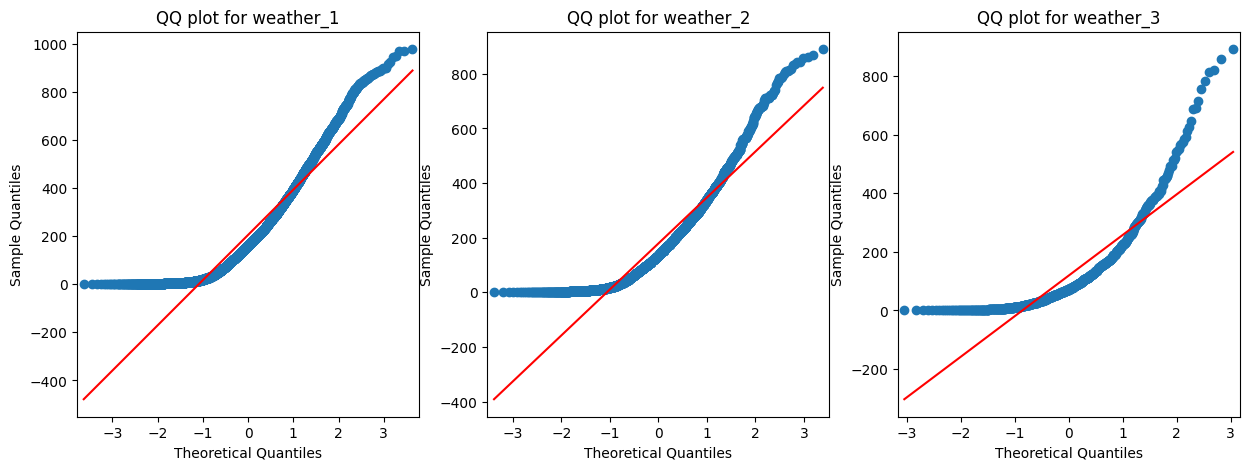

In [384]:
# Visual check for normality
weather_1 = df.loc[df["weather"] == 1, "count"]
weather_2 = df.loc[df["weather"] == 2, "count"]
weather_3 = df.loc[df["weather"] == 3, "count"]
weather_4 = df.loc[df["weather"] == 4, "count"]

fig, axs = plt.subplots(1,3, figsize = (15,5))

qqplot(weather_1, line = "s", ax = axs[0])
axs[0].set_title("QQ plot for weather_1")

qqplot(weather_2, line = "s", ax = axs[1])
axs[1].set_title("QQ plot for weather_2")

qqplot(weather_3, line = "s", ax = axs[2])
axs[2].set_title("QQ plot for weather_3")


plt.show()

visually data is not normal

In [385]:
# Statistical test for normality: Shapiro Wilk test

# H0 : Data is Gaussian
# H1 : Dat is not Gaussian

# If the p-value is high (greater than, say, 0.05),
# It suggests that the data likely does come from a normal distribution.

# Conversely, if the p-value is low (less than 0.05),
# It indicates that the data's distribution significantly differs from a normal distribution.

test_stat, p_value = shapiro(weather_1.sample(100))
if p_value < 0.05:
  print("Data is not normal for weather_1")
else:
  print("Data is normal")


test_stat, p_value = shapiro(weather_2.sample(100))
if p_value < 0.05:
  print("Data is not normal for weather_2")
else:
  print("Data is normal")

test_stat, p_value = shapiro(weather_3.sample(100))
if p_value < 0.05:
  print("Data is not normal for weather_3")
else:
  print("Data is normal")



Data is not normal for weather_1
Data is not normal for weather_2
Data is not normal for weather_3


By shapiro test it is obeserved that data is not normal



---
Check for variance of data for each weather

Another assumption of ANOVA is that: There should be equal variance in different groups/categories in our data.


Variance for each weather
1    35328.798463
2    28347.248993
3    19204.775893
Name: count, dtype: float64


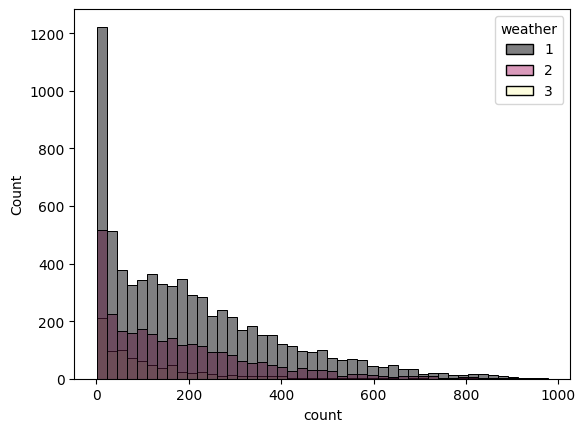

In [386]:
# Visual check for variance
sns.histplot(data = df, x = "count", hue = "weather", palette = "magma")
print("Variance for each", df.groupby(by = "weather")["count"].var())

Visually it is difficult to understand variance

In [389]:
test_stat, p_value = levene(weather_1, weather_2, weather_3)

if p_value < 0.05:
  print("There is difference in Variance")
else:
  print("Variance is same for all weather")

print()
print("Test statistic:", test_stat)
print("p_value:", p_value)

There is difference in Variance

Test statistic: 81.67574924435011
p_value: 6.198278710731511e-36


By levene test it is obeserved that data has difference in variance.



---

Since Both assuptions for ANONA are failed we cannot use f-oneway, lets test Kruskal-Wallis test

In [390]:
test_stat, p_value = kruskal(weather_1, weather_2, weather_3)
if p_value < 0.05:
  print("No. of cycles rented are different in different weather / States that at least one of the means is different/ weather affect count of bike rented.")
else:
  print("No. of cycles rented are similar irrespective of weather/ States that the means of all groups are equal.")

print()
print("Test statistic:", test_stat)
print("p_value:", p_value)

No. of cycles rented are different in different weather / States that at least one of the means is different/ weather affect count of bike rented.

Test statistic: 204.95566833068537
p_value: 3.122066178659941e-45


Conclusion 4: After performing Kruskal Wallis Test No. of cycles rented are different in different weather / States that at least one of the means is different/ weather affect count of bike rented.



---


**Hypothesis Testing 5**

Weather vs Season (Chisquare Test): Categorical vs Categorical

Q4. Is weather dependent on season?

H0 Null hypothesis: weather and season are independant

Alternate hypothesis: weather and season are dependant

Significant Level/ alpha = 0.05


In [396]:
link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/428/original/bike_sharing.csv?1642089089"
df = pd.read_csv(link)

In [408]:
table = pd.crosstab(df['weather'], df['season'])
table

season,1,2,3,4
weather,,,,
1,1759,1801,1930,1702
2,715,708,604,807
3,211,224,199,225
4,1,0,0,0


Text(0.5, 1.0, 'Heatmap showing counts for seans vs weather')

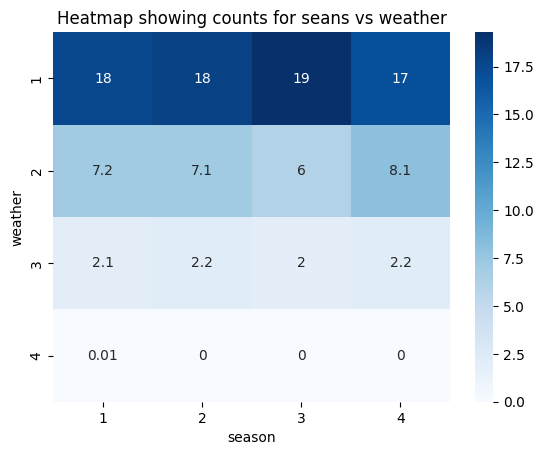

In [418]:
sns.heatmap(table/100, annot = True, cmap = "Blues")
plt.title("Heatmap showing counts for seans vs weather")

In [426]:
# Performing Chisquare Contengency test for checking dependance of Variables

statistic, pvalue, dof, expected_freq =  chi2_contingency(table)

if pvalue < 0.05:
  print("weather and season are dependant")
else:
  print("weather and season are independant")

print()

print("Test statistic:", statistic)
print("p_value:", pvalue)

weather and season are dependant

Test statistic: 49.15865559689363
p_value: 1.5499250736864862e-07


Conclusion 5: After performing hisquare Contengency test weather and season are dependant on each other.




---


**Statistical Analysis**

**Bivariate Analysis:** Showed no significant difference in rentals between working and non-working days.

**T-tests:** Confirmed that neither working days nor holidays significantly affect rental counts.

**Kruskal-Wallis Test:** Identified significant differences in cycle rentals across seasons, suggesting a strong seasonal component to demand.

**Chi-Square Test:** Established a dependency between weather conditions and bike rentals, reinforcing the influence of environmental factors.



---




**Inference from the analysis**

**Temporal Patterns:**

* The data highlights a growth trend in electric cycle usage, notably peaking in 2012 compared to the previous year.

* Seasonal shifts are evident, with summers (July-September) witnessing heightened bike rentals, while winters (January-March) show a decline in usage.

Weather and Seasonal Influence:

* Weather significantly impacts bike rental rates; favorable conditions like sunny days correlate with increased rentals, while adverse weather, such as rain or cold, reduces demand.

* Moreover, the data reveals distinct preferences for cycling during specific seasons, indicating a clear seasonal influence on usage patterns.

Usage Consistency Across Days:

* Contrary to expectations, weekdays and holidays exhibit similar demand for bikes, suggesting a consistent usage trend regardless of the day type.



---


**Additional Views**

1. Analyzing how different demographics (age, income level, occupation) affect the demand for shared electric cycles could be beneficial.

2. Considering external factors such as public transport strikes, local events, or changes in fuel prices could provide depth to the understanding of demand shifts.

In [428]:
!jupyter nbconvert --to pdf /content/Yulu_Business_Case.ipynb

[NbConvertApp] Converting notebook /content/Yulu_Business_Case.ipynb to pdf
[NbConvertApp] Support files will be in Yulu_Business_Case_files/
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory ./Yulu_Business_Case_files
[NbConvertApp] Making directory 